<a href="https://colab.research.google.com/github/weiyw16/Middle_Layer_Inverse/blob/main/examine_CNN_saliencymap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# requirements
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pcl
import torch
import torch.nn.functional as F
from torch.autograd import Variable
mydevice = torch.device('cuda:' + str(0) if torch.cuda.is_available() else "cpu")
print(f"Running on device: {mydevice}")

Running on device: cpu


In [13]:
# functions

## backward Conv2d(bias) + ReLu
def manual_backward_conv(alyer1=None, weigh=None, 
                         n0=2048, n1=128, s0=2, s1=2, p0=1, p1=1):
  '''
  layer 0: [n0, n1]
  alyer1 : data of layer 1 
  weigh  : weight of kernel in the convolutional layer
  s0, s1 : stride of kernel
  p0, p1 : padding of kernel

  return
  glyer0 : gradient of layer 0
  '''
  # init
  glyer0 = np.zeros((n0+2*p0, n1+2*p1))
  [k0,k1] = weigh.shape
  # reverse ReLu
  alyer1[alyer1 > 0] = 1
  # reverse conv
  for ii in range(alyer1.shape[0]):
    for jj in range(alyer1.shape[1]):
        glyer0[s0*ii:s0*ii+k0, s1*jj:s1*jj+k1] += weigh * alyer1[ii, jj]
        
  return glyer0[p0:p0+n0, p1:p1+n1]
      


In [6]:
# function
def plot_1(OUT=None, scale=None, saveflag=None, savename=None, scratio=128/1200):
    '''
    :param OUT: the target array to plot
    :param scale: plot scaling
    :return:  None
    '''    
    # scale case 1
    sc1 = OUT.mean() - scale*OUT.std()
    sc2 = OUT.mean() + scale*OUT.std()
    cN = pcl.Normalize(vmin=sc1, vmax=sc2)

    # plotting
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(OUT, aspect=scratio, cmap='seismic', norm=cN, interpolation='bicubic')
    
    plt.colorbar(im, shrink=0.3, orientation='horizontal')
    plt.axis('off')
    
    saveflag = False
    if saveflag:
        plt.savefig(savename, dpi=300, bbox_inches="tight")

In [17]:
## example

# init
x = torch.ones(1,1,4,4, requires_grad=True)
w = torch.ones(1, 1, 3, 3, requires_grad=False) 
bias = np.array([-4])
biasT = torch.from_numpy(bias).to(torch.float32)
self_relu = torch.nn.ReLU(inplace=True)
# forward
y = F.conv2d(x, w, bias=biasT, stride=2, padding=1)
z = y
z = self_relu(z)
out = z.sum()

print(f"x,{x}")
print(f"w,{w}")
print(f"y,{y}")
print(f"z,{z}")
print(f"out,{out}")

# backward
out.backward()
ref_grad = x.grad
print(ref_grad)

# manually backward
manu_grad = manual_backward_conv(alyer1=z[0,0,:,:].detach().numpy(), 
                                 weigh=w[0,0,:,:].numpy(), 
                                 n0=4, n1=4, s0=2, s1=2, p0=1, p1=1)

# difference between manully backward and Pytorch auto backward
diff = manu_grad - ref_grad.detach().numpy()
print(f"diff: {diff}")

x,tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]], requires_grad=True)
w,tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])
y,tensor([[[[0., 2.],
          [2., 5.]]]], grad_fn=<ReluBackward0>)
z,tensor([[[[0., 2.],
          [2., 5.]]]], grad_fn=<ReluBackward0>)
out,9.0
tensor([[[[0., 1., 1., 1.],
          [1., 3., 2., 2.],
          [1., 2., 1., 1.],
          [1., 2., 1., 1.]]]])
diff: [[[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]]]


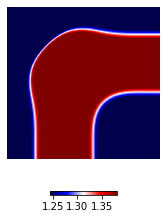

In [18]:
plot_1(OUT=manu_grad, scale=0.1, saveflag=None, savename=None, scratio=1)